# **CS224W - Colab 4**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scpd-proed/XCS224W-Colab4/blob/main/Notebook/XCS224W_Colab4.ipynb)

Before opening the colab with the badge, you would need to allow Google Colab to access the GitHub private repositories. Please check therefore [this tutorial](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#:~:text=Navigate%20to%20http%3A%2F%2Fcolab,to%20read%20the%20private%20files.).

If colab is opened with this badge, make sure please **save copy to drive** in 'File' menu before running the notebook.

In this Colab, we shift our focus from homogenous graphs to heterogeneous graphs. Heterogeneous graphs extend the traditional homogenous graphs that we have been working with by incorporating different node and edge types. This additional information allows us to extend the graph neural nework models that we have worked with before. Namely, we can apply heterogenous message passing, where different message types now exist between different node and edge type relationships. 

In this notebook, you will first learn how to transform NetworkX graphs into DeepSNAP representations. Then, you will dive deeper into how DeepSNAP stores and represents heterogeneous graphs as PyTorch Tensors.

With this knowledge, you will build your own heterogenous graph neural netowrk models using PyTorch Geometric and DeepSNAP. You will then apply your models for a node property prediction task; specifically, you will evaluate these models on the heterogeneous ACM node prediction dataset.

Lastly, we give a sneak preview into the work you will do on Colab5. To close out this assignment we introduce the concept of Neighborhood Sampling and mini-batch training for scaling GNNs to large graphs.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

Have fun and good luck on Colab 4 :)

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

## Setup
First let us check which version of PyTorch you are running

In [1]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.4.0


Download the necessary packages for PyG. Make sure that your version of torch matches the output from the cell above. In case of any issues, more information can be found on the [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [2]:
# # Install torch geometric
# import os
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#   !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
#   !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
#   !pip install torch-geometric
#   # Fix for Deepsnap PyG 2.4.x compatibility issue (https://github.com/snap-stanford/deepsnap/issues/53)
#   !pip install -q git+https://github.com/SebastianHurubaru/deepsnap.git
#   !pip install -U -q x

In [3]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !nvcc --version
  !python -c "import torch; print(torch.version.cuda)"

zsh:1: command not found: nvcc
None


In [4]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  import torch
  import torch_geometric
  print(torch.__version__)
  print(torch_geometric.__version__)

2.4.0
2.6.1


# 1) DeepSNAP Heterogeneous Graph

First, you will explore how to transform a NetworkX graph into the format supported by DeepSNAP. 

DeepSNAP extends its traditional graph representation to include heterogeneous graphs by including the following graph property features:  
* `node_feature`: The feature of each node (`torch.tensor`)
* `edge_feature`: The feature of each edge (`torch.tensor`)
* `node_label`: The label of each node (`int`)
* `node_type`: The type of each node (`string`)
* `edge_type`: The type of each edge (`string`)

where the key **new** features added are `node_type` and `edge_type`, which enables us to perform heterogenous message passing.

For this first question you will work with the familiar [karate club graph](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html) seen in Colab 1. To start, since each node in the graph belongs to one of two clubs (club "Mr. Hi" or club "Officer"), you will treat the club as the `node_type`. The code below demonstrates how to differentiate the nodes in the NetworkX graph.


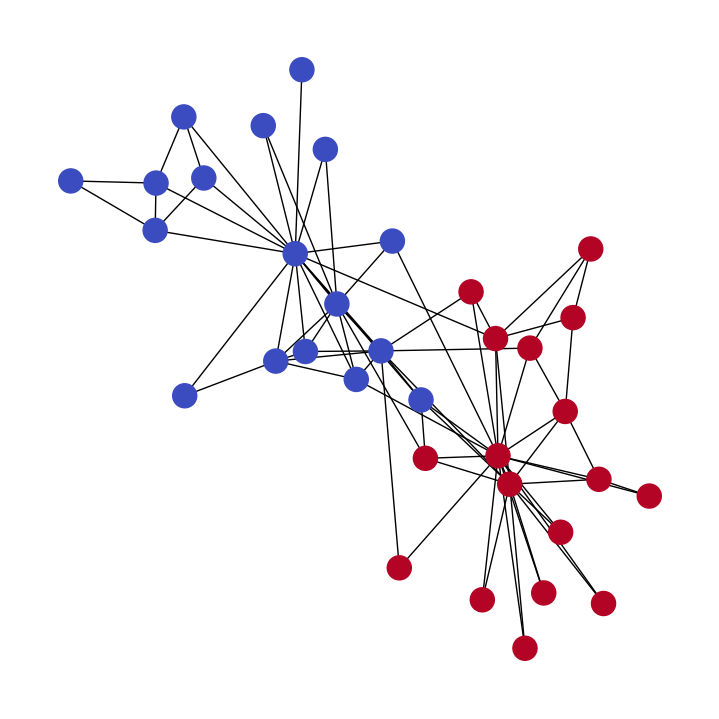

In [5]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

if 'IS_GRADESCOPE_ENV' not in os.environ:
  from pylab import show
  G = nx.karate_club_graph()
  community_map = {}
  for node in G.nodes(data=True):
    if node[1]["club"] == "Mr. Hi":
      community_map[node[0]] = 0
    else:
      community_map[node[0]] = 1
  node_color = []
  color_map = {0: 0, 1: 1}
  node_color = [color_map[community_map[node]] for node in G.nodes()]
  pos = nx.spring_layout(G)
  plt.figure(figsize=(7, 7))
  nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
  show()

### Question 1.1: Assigning Node Type and Node Features (10 points)

Using the `community_map` dictionary and graph `G` from above, add node attributes `node_type` and `node_label` to the graph G. Namely, for `node_type` assign nodes in the "Mr. Hi" club to a node type `n0` and nodes in club "Officer" a node type `n1`. Note: the node type should be a `string` property.

Then for `node_label`, assign nodes in "Mr. Hi" club to a `node_label` `0` and nodes in club "Officer" a `node_label` of `1`.

Lastly, assign every node the *tensor* feature vector $[1, 1, 1, 1, 1]$. 

**Hint**: Look at the NetworkX function `nx.classes.function.set_node_attributes`.

In [6]:
import torch

def assign_node_types(G, community_map):
  # TODO: Implement a function that takes in a NetworkX graph
  # G and community map assignment (mapping node id --> 0/1 label)
  # and adds 'node_type' as a node_attribute in G.

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
  ## 2. Look above for the two node type values!
  # pass
  #########################################
  node_types = {}
  for node in G.nodes():
    node_types[node] = "n0" if community_map[node] == 0 else "n1"
  
  print("Before assign_node_types", G.nodes[0])
  nx.classes.function.set_node_attributes(G , node_types, 'node_type')
  print("After assign_node_types", G.nodes[0])
  

def assign_node_labels(G, community_map):
  # TODO: Implement a function that takes in a NetworkX graph
  # G and community map assignment (mapping node id --> 0/1 label)
  # and adds 'node_label' as a node_attribute in G.

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
  # pass
  #########################################
  print("Before assign_node_labels", G.nodes[0])
  nx.classes.function.set_node_attributes(G , community_map, 'node_label')
  print("After assign_node_labels", G.nodes[0])

def assign_node_features(G):
  # TODO: Implement a function that takes in a NetworkX graph
  # G and adds 'node_feature' as a node_attribute in G. Each node
  # in the graph has the same feature vector - a torchtensor with 
  # data [1., 1., 1., 1., 1.]

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
  # pass
  #########################################
  print("Before assign_node_features", G.nodes[0])
  nx.classes.function.set_node_attributes(G , torch.ones(5), 'node_feature')
  print("After assign_node_features", G.nodes[0])
  

if 'IS_GRADESCOPE_ENV' not in os.environ:
  assign_node_types(G, community_map)
  assign_node_labels(G, community_map)
  assign_node_features(G)

  # Explore node properties for the node with id: 20
  node_id = 20
  print (f"Node {node_id} has properties:", G.nodes(data=True)[node_id])

Before assign_node_types {'club': 'Mr. Hi'}
After assign_node_types {'club': 'Mr. Hi', 'node_type': 'n0'}
Before assign_node_labels {'club': 'Mr. Hi', 'node_type': 'n0'}
After assign_node_labels {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0}
Before assign_node_features {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0}
After assign_node_features {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': tensor([1., 1., 1., 1., 1.])}
Node 20 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': tensor([1., 1., 1., 1., 1.])}


### Question 1.2: Assigning Edge Types (2.5 points)

Next, we will assign three different `edge_types`: 
* Edges within club "Mr. Hi": `e0`
* Edges within club "Officer": `e1`
* Edges between the two clubs: `e2`

**Hint**: Use the `community_map` from before and `nx.classes.function.set_edge_attributes`

In [7]:
def assign_edge_types(G, community_map):
  # TODO: Implement a function that takes in a NetworkX graph
  # G and community map assignment (mapping node id --> 0/1 label)
  # and adds 'edge_type' as a edge_attribute in G.

  ############# Your code here ############
  ## (~5 line of code)
  ## Note
  ## 1. Create an edge assignment dict following rules above
  ## 2. Look up NetworkX `nx.classes.function.set_edge_attributes`
  # pass
  #########################################
  
  edge_community = {}
  for e1,e2 in G.edges():
    
    if community_map[e1] == 0 and community_map[e2] == 0:
      edge_community[(e1,e2)] = "e0"
    elif  community_map[e1] == 1 and community_map[e2] == 1:
      edge_community[(e1,e2)] = "e1"
    else:
       edge_community[(e1,e2)] = "e2"
        
  print("Before assign_edge_types", G.edges[0,31])
  nx.classes.function.set_edge_attributes(G , edge_community, 'edge_type')
  print("After assign_edge_types", G.edges[0,31])

if 'IS_GRADESCOPE_ENV' not in os.environ:
  assign_edge_types(G, community_map)

  # Explore edge properties for a sampled edge and check the corresponding
  # node types
  edge_idx = 15
  n1 = 0
  n2 = 31
  edge = list(G.edges(data=True))[edge_idx]
  print (f"Edge ({edge[0]}, {edge[1]}) has properties:", edge[2])
  print (f"Node {n1} has properties:", G.nodes(data=True)[n1])
  print (f"Node {n2} has properties:", G.nodes(data=True)[n2])

Before assign_edge_types {'weight': 2}
After assign_edge_types {'weight': 2, 'edge_type': 'e2'}
Edge (0, 31) has properties: {'weight': 2, 'edge_type': 'e2'}
Node 0 has properties: {'club': 'Mr. Hi', 'node_type': 'n0', 'node_label': 0, 'node_feature': tensor([1., 1., 1., 1., 1.])}
Node 31 has properties: {'club': 'Officer', 'node_type': 'n1', 'node_label': 1, 'node_feature': tensor([1., 1., 1., 1., 1.])}


## Heterogeneous Graph Visualization

Now we can visualize the Heterogeneous Graph we have generated.

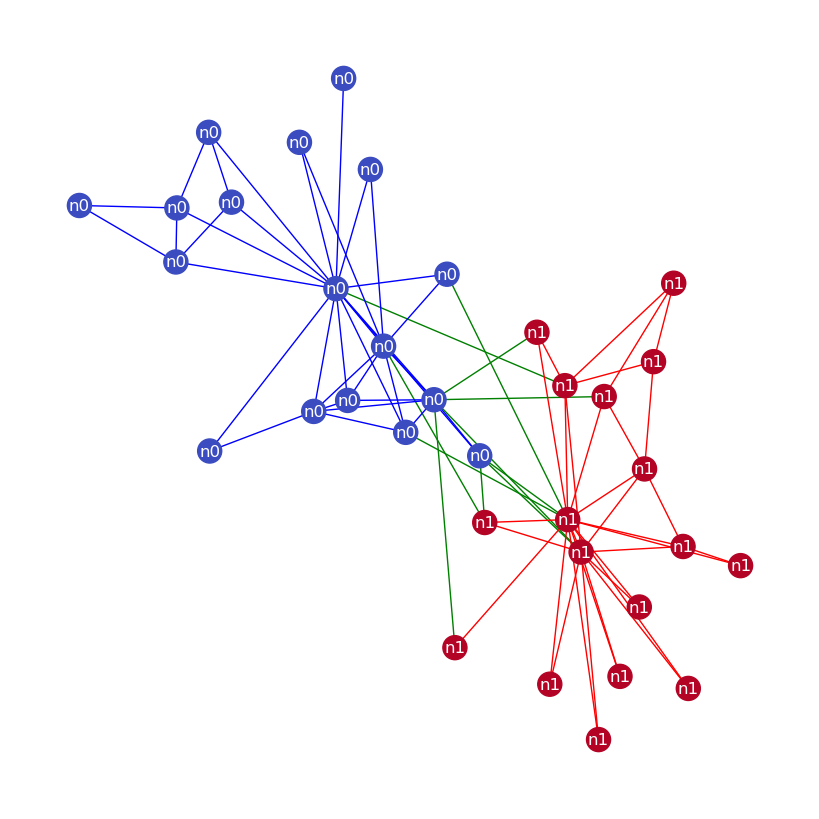

In [8]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  edge_color = {}
  for edge in G.edges():
    n1, n2 = edge
    edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
    if community_map[n1] == community_map[n2] and community_map[n1] == 0:
      edge_color[edge] = 'blue'
    elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
      edge_color[edge] = 'red'
    else:
      edge_color[edge] = 'green'

  G_orig = copy.deepcopy(G)
  nx.classes.function.set_edge_attributes(G, edge_color, name='color')
  colors = nx.get_edge_attributes(G,'color').values()
  labels = nx.get_node_attributes(G, 'node_type')
  plt.figure(figsize=(8, 8))
  nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
  show()

You should see that we differentiate edges within each clubs (2 types) and edges between the two clubs (1 type). Different types of nodes and edges are visualized in different colors. The NetworkX object `G` in following code can be transformed into `deepsnap.hetero_graph.HeteroGraph` directly.

## Transforming to DeepSNAP representation

You will now work through transforming the NetworkX object `G` into a `deepsnap.hetero_graph.HeteroGraph`.

In [9]:
from deepsnap.hetero_graph import HeteroGraph

if 'IS_GRADESCOPE_ENV' not in os.environ:
  hete = HeteroGraph(G_orig)
  print(hete)

HeteroGraph(G=[], club=[], edge_index=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[78], edge_type=[], name=[], node_feature=[], node_label=[], node_label_index=[], node_to_graph_mapping=[], node_to_tensor_mapping=[34], node_type=[], weight=[])


## Question 1.3: How many nodes are of each type (2.5 Points)


In [10]:
def get_nodes_per_type(hete):
  # TODO: Implement a function that takes a DeepSNAP dataset object
  # and return the number of nodes per `node_type`.

  num_nodes_n0 = 0
  num_nodes_n1 = 0
  # print(hete.node_type)

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful.
  # pass
  #########################################
  num_nodes_n0 = len(hete.node_type["n0"])
  num_nodes_n1 = len(hete.node_type["n1"])

  return num_nodes_n0, num_nodes_n1

if 'IS_GRADESCOPE_ENV' not in os.environ:
  num_nodes_n0, num_nodes_n1 = get_nodes_per_type(hete)
  print("Node type n0 has {} nodes".format(num_nodes_n0))
  print("Node type n1 has {} nodes".format(num_nodes_n1))

Node type n0 has 17 nodes
Node type n1 has 17 nodes


## Question 1.4: Message Types - How many edges are of each message type (2.5 Points)

When working with heterogenous graphs, we now have heterogenous message types (i.e. different message types for the different `node_type` and `edge_type` combinations). For example, an edge of type `e0` connecting two nodes in club "Mr. HI" would have a message type of (`n0`, `e0`, `n0`). In this problem we will analyze how many edges in our graph are of each message type.

**Hint**: If you want to learn more about what the different message types are try the call `hete.message_types`

In [11]:
def get_num_message_edges(hete):
  # TODO: Implement this function that takes a DeepSNAP dataset object
  # and return the number of edges for each message type. 
  # You should return a list of tuples as 
  # (message_type, num_edge)

  message_type_edges = []
  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful.
  # pass
  #########################################
  
  for message_type in hete.message_types:
    # print(hete.edge_type)
    # print(message_type)
    num_edge = len(hete.edge_type[message_type])
    message_type_edges.append((message_type , num_edge)) 

  return message_type_edges

if 'IS_GRADESCOPE_ENV' not in os.environ:
  message_type_edges = get_num_message_edges(hete)
  for (message_type, num_edges) in message_type_edges:
    print("Message type {} has {} edges".format(message_type, num_edges))

Message type ('n0', 'e0', 'n0') has 35 edges
Message type ('n0', 'e2', 'n1') has 11 edges
Message type ('n1', 'e1', 'n1') has 32 edges


## Question 1.5: Dataset Splitting - How many nodes are in each dataset split? (2.5 Points)

DeepSNAP has built in Dataset creation and splitting methods for heterogeneous graphs. Here you will create train, validation, and test datasets for a node prediction task and inspect the resulting subgraphs. Specifically, write a function that computes the number of nodes with a known label in each dataset split.


In [12]:
from deepsnap.dataset import GraphDataset

def compute_dataset_split_counts(datasets):
  # TODO: Implement a function that takes a dict of datasets in the form
  # {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}
  # and returns a dict mapping dataset names to the number of labeled
  # nodes used for supervision in that respective dataset.  
  
  data_set_splits = {}
  # print(datasets)
  # print(datasets["train"][0])

  ############# Your code here ############
  ## (~3 line of code)
  ## Note
  ## 1. The DeepSNAP `node_label_index` dictionary will be helpful.
  ## 2. Remember to count both node_types
  ## 3. Remember each dataset only has one graph that we need to access 
  ##    (i.e. dataset[0])
  # pass
  #########################################
  
  for dataset_name in datasets:
    # print("for",datasets[dataset_name][0].node_label_index)
    data_set_splits[dataset_name] = len(datasets[dataset_name][0].node_label_index["n0"]) +  len(datasets[dataset_name][0].node_label_index["n1"])
    
  
  # print(data_set_splits)

  return data_set_splits

if 'IS_GRADESCOPE_ENV' not in os.environ:
  dataset = GraphDataset([hete], task='node')
  # Splitting the dataset
  dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
  datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

  data_set_splits = compute_dataset_split_counts(datasets)
  for dataset_name, num_nodes in data_set_splits.items():
    print("{} dataset has {} nodes".format(dataset_name, num_nodes))

train dataset has 12 nodes
val dataset has 10 nodes
test dataset has 12 nodes


## DeepSNAP Dataset Visualization

Now you can visualize the different nodes and edges used in each graph dataset split.

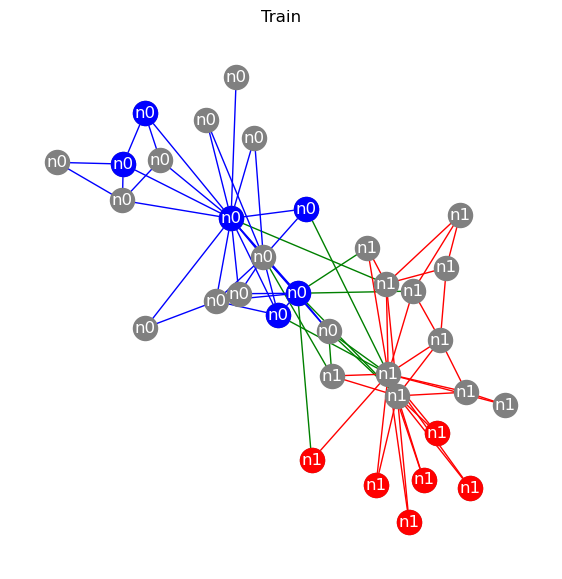

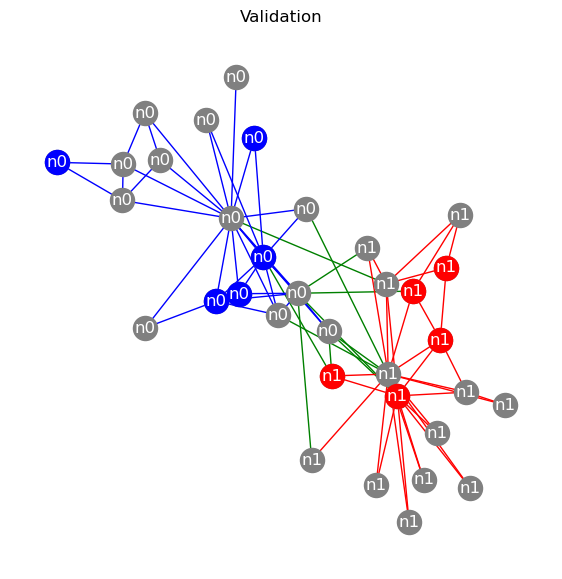

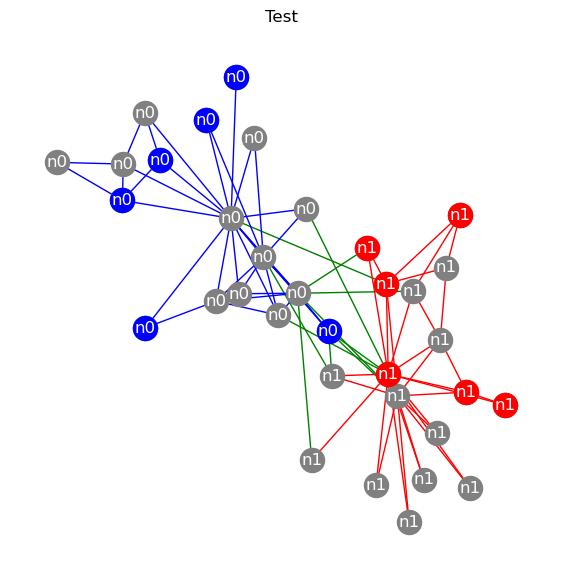

In [13]:
from deepsnap.dataset import GraphDataset

if 'IS_GRADESCOPE_ENV' not in os.environ:
  dataset = GraphDataset([hete], task='node')
  # Splitting the dataset
  dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
  titles = ['Train', 'Validation', 'Test']

  for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    n0 = hete._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
    n1 = hete._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

    plt.figure(figsize=(7, 7))
    plt.title(titles[i])
    nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
    nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
    nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
    show()

# 2) Heterogeneous Graph Node Property Prediction

Now that we have introduced you to the basics of Heterogeneous graphs, you will use PyTorch Geometric and DeepSNAP to implement a GNN model for heterogeneous graph node property prediction (node classification). You will draw upon your understanding of heterogeneous graphs from lecture and previous work in implementing GNN layers using PyG (introduced in Colab 3).

First let's take a look at the general structure of a heterogeneous GNN layer by working through an example:

Let's assume we have a graph $G$, which contains two node types $a$ and $b$, and three message types $m_1=(a, r_1, a)$, $m_2=(a, r_2, b)$ and $m_3=(a, r_3, b)$. For notation sake, we view each message as (src, relation, dst), where messages "flow" from src to dst node types. 

When applying message passing in heterogenous graphs, we separately apply message passing over each message type separately. For example, updating node type $b$ relies on two different message types $m_2$ and $m_3$. For the graph $G$, a heterogeneous GNN layer contains three separate Heterogeneous Message Passing layers (`HeteroGNNConv` in this Colab), where each `HeteroGNNConv` layer performs message passing and aggregation with respect to *only one message type*. Since a message type is viewed as (src, relation, dst) and messages "flow" from src to dst, each `HeteroGNNConv` layer only computes embeddings for the *dst* nodes of a given message type. For example, the `HeteroGNNConv` layer for message type $m_2$ outputs updated embedding representations *only* for node's with type b. 

---

An overview of the heterogeneous layer you will create is shown below:

![test](Colab04/image.png)

where we highlight the following notation:

- $H_a^{(l)[m_1]}$ is the intermediate matrix of node embeddings for node type $a$, generated by the $l^{th}$ `HeteroGNNConv` layer for message type $m_1$.
- $H_a^{(l)}$ is the matrix with current embeddings for nodes of type $a$ after the $l^{th}$ layer of our Heterogeneous GNN model. Note that these embeddings can rely on one or more intermediate `HeteroGNNConv` layer embeddings(i.e. $H_b^{(l)}$ combines $H_b^{(l)[m_2]}$ and $H_b^{(l)[m_3]}$).

Since each `HeteroGNNConv` is only applied over a single message type, we additionally define a Heterogeneous GNN Wrapper layer (`HeteroGNNWrapperConv`). This wrapper manages and combines the output of each `HeteroGNNConv` layer in order to generate the complete updated node embeddings for each node type in layer $l$ of our model. More specifically, the $l^{th}$ `HeteroGNNWrapperConv` layer takes as input the node embeddings computed for each message type and node type (e.g. $H_b^{(l)[m_2]}$ and $H_b^{(l)[m_3]}$) and aggregates across message types with the same $dst$ node type. The resulting output of the $l^{th}$ `HeteroGNNWrapperConv` layer is the updated embedding matrix $H_i^{(l)}$ for each node type i. 

Continuing on our example above, to compute the node embeddings $H_b^{(l)}$, the wrapper layer aggregates output embeddings from the `HeteroGNNConv` layers associated with message types $m_2$ and $m_3$ (i.e. $H_b^{(l)[m_2]}$ and $H_b^{(l)[m_3]}$). 

---

With the `HeteroGNNWrapperConv` module, we can now draw a "simplified" heterogeneous layer structure as follows:

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/hetero_conv_1.png"/>
</center>
<br/>

---
**NOTE**: 
As reference, it may be helpful to additionally read through PyG's introduction to heterogeneous graph representations and buidling heterogeneous GNN models: https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html 

<font color='red'>Looking ahead, we recommend you implement the heterogeneous GNN model in following steps:</font>

1. Implement `HeteroGNNConv`.
2. Implement **just** `mean` aggregation within `HeteroGNNWrapperConv`.
3. Implement `generate_convs`.
4. Implement the `HeteroGNN` model and the `train` function.
5. Train the model with `mean` aggregation and test your model to make sure your model has reasonable performance.
6. Once you are confident in your mean aggregation model, implement `attn` aggregation in `HeteroGNNWrapperConv`.
7. Train the model with `attn` aggregation and test your model to make sure your model has reasonable performance.

Note: The key point of advice is to work completely through implementing the mean aggregation heterogeneous GNN model before diving into the more difficult attention based model.

## Setup

In [14]:
import copy
import torch
import deepsnap
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul

## Dataset

If you are working over Google Colab, you would need to login to your Google account and enter the verification code below. If on the other hand you are working locally, you should comment out the following two related cells downloading the data from Google Drive, as the file is already part of the repository and therefore is locally available!

In [15]:
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#   from pydrive.auth import GoogleAuth
#   from pydrive.drive import GoogleDrive
#   from google.colab import auth
#   from oauth2client.client import GoogleCredentials

#   # Authenticate and create the PyDrive client
#   auth.authenticate_user()
#   gauth = GoogleAuth()
#   gauth.credentials = GoogleCredentials.get_application_default()
#   drive = GoogleDrive(gauth)

In [16]:
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#   id='1ivlxd6lJMcZ9taS44TMGG72x2V1GeVvk'
#   downloaded = drive.CreateFile({'id': id})
#   downloaded.GetContentFile('acm.pkl')

## Implementing `HeteroGNNConv`

Now let's start working on your own implementation of the heterogeneous message passing layer (`HeteroGNNConv`)! Just as in Colab 3, you will implement the layer using PyTorch Geometric. 

At a high level, the `HeteroGNNConv` layer is equivalent to the homogenous GNN layers you implemented in Colab 3, but now applied to an individual heterogeneous message type. Moreover, our heterogeneous GNN layer draws directly from the **GraphSAGE** message passing model ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)).

You will begin by defining the `HeteroGNNConv` layer with respect to message type $m$:

\begin{equation}
m =(s, r, d)
\end{equation}

where each message type is a tuple containing three elements: $s$ - the source node type, $r$ - the edge (relation) type, and $d$ - the destination node type. 

The message passing update rule that you will implement is very similar to that of GraphSAGE, except you now need to include the node types and the edge relation type. The update rule for message type $m$ is described below:

\begin{equation}
h_v^{(l)[m]} = W^{(l)[m]} \cdot \text{CONCAT} \Big( W_d^{(l)[m]} \cdot h_v^{(l-1)}, W_s^{(l)[m]} \cdot AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \})\Big)
\end{equation}

where you compute $h_v^{(l)[m]}$, the node embedding representation for node $v$ after `HeteroGNNConv` layer $l$ with respect message type $m$. Further unpacking the formula:
- $W_s^{(l)[m]}$ - linear transformation matrix for the messages of neighboring source nodes of type $s$ along message type $m$.
- $W_d^{(l)[m]}$ - linear transformation matrix for the message from the node $v$ itself of type $d$.
- $W^{(l)[m]}$ - linear transformation matrix for the concatenated messages from neighboring node's and the central node.
- $h_u^{(l-1)}$ - the hidden embedding representation for node $u$ after the $(l-1)^{th}$ `HeteroGNNWrapperConv` layer. Note, that this embedding is not associated with a particular message type (see layer diagrams above). 
- $N_{m}(v)$ - the set of neighbor source nodes $s$ for the node v that we are embedding along message type $m = (s, r, d)$. 

**NOTE**: We emphasize that each weight matrix is associated with a specific message type $[m]$ and additionally, the weight matrices applied to node messages are differentiated by node type (i.e. $W_s$ and $W_d$).

Lastly, for simplicity, we use mean aggregations for $AGG$ where:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \}) = \frac{1}{|N_{m}(v)|} \sum_{u\in N_{m}(v)} h_u^{(l-1)}
\end{equation}

In [17]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        # To simplify implementation, please initialize both self.lin_dst
        # and self.lin_src out_features to out_channels
        self.lin_dst = nn.Linear(in_features=self.in_channels_src , out_features=self.out_channels )
        self.lin_src = nn.Linear(in_features=self.in_channels_dst , out_features=self.out_channels )

        self.lin_update = nn.Linear(in_features=  2* self.out_channels , out_features=self.out_channels ) ## not sure about this

        ############# Your code here #############
        ## (~3 lines of code)
        ## Note:
        ## 1. Initialize the 3 linear layers.
        ## 2. Think through the connection between the mathematical
        ##    definition of the update rule and torch linear layers!
        # pass
        ##########################################

    def forward(
        self,
        node_feature_src,
        node_feature_dst,
        edge_index,
        size=None
    ):
        ############# Your code here #############
        ## (~1 line of code)
        ## Note:
        ## 1. Unlike Colab 3, we just need to call self.propagate with 
        ## proper arguments and return its output.
        # pass
        ##########################################
        return self.propagate(edge_index, size=size,node_feature_src=node_feature_src, node_feature_dst=node_feature_dst)

    def message_and_aggregate(self, edge_index, node_feature_src):

        ############# Your code here #############
        ## (~1 line of code)
        ## Note:
        ## 1. Different from what we implemented in Colab 3, we use message_and_aggregate
        ##    to combine the previously seperate message and aggregate functions. 
        ##    The benefit is that we can avoid materializing x_i and x_j
        ##    to make the implementation more efficient.
        ## 2. To implement efficiently, refer to PyG documentation for message_and_aggregate
        ##    and sparse-matrix multiplication:
        ##    https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
        ## 3. Here edge_index is torch_sparse SparseTensor. Although interesting, you
        ##    do not need to deeply understand SparseTensor represenations!
        ## 4. Conceptually, think through how the message passing and aggregation
        ##    expressed mathematically can be expressed through matrix multiplication.
        # pass
        ##########################################
        out = matmul(edge_index, node_feature_src, reduce=self.aggr)

        return out
    
        

    def update(self, aggr_out, node_feature_dst):

        ############# Your code here #############
        ## (~4 lines of code)
        ## Note:
        ## 1. The update function is called after message_and_aggregate
        ## 2. Think through the one-one connection between the mathematical update
        ##    rule and the 3 linear layers defined in the constructor. 
        # pass
        ##########################################
        aggr_out = self.lin_src(aggr_out)
        node_feature_dst = self.lin_dst(node_feature_dst)
        concatenated = torch.cat([node_feature_dst,aggr_out], dim=-1)
        
        aggr_out = self.lin_update(concatenated)
        

        return aggr_out

## Heterogeneous GNN Wrapper Layer

After implementing the `HeteroGNNConv` layer for each message type, you need to manage and aggregate the node embedding results (with respect to each message types). Here you will implement two types of message type level aggregation.

The first one is simply mean aggregation over message types:

\begin{equation}
h_v^{(l)} = \frac{1}{M}\sum_{m=1}^{M}h_v^{(l)[m]}
\end{equation}

where node $v$ has node type $d$ and we sum over the $M$ message types that have destination node type $d$. From our original example, for a node v of type $b$ you aggregate v's `HeteroGNNConv` embeddings for message types $m_2$ and $m_3$ (i.e. $h_v^{(l)[m_2]}$ and $h_v^{(l)[m_3]}$).

The second method you will implement is the semantic level attention introduced in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)). Instead of directly averaging on the message type aggregation results, you use attention to learn which message type result is more important, then aggregate across all the message types. Below are the equations for semantic level attention:

\begin{equation}
e_{m} = \frac{1}{|V_{d}|} \sum_{v \in V_{d}} q_{attn}^{(l)T} \cdot tanh \Big( W_{attn}^{(l)} \cdot h_v^{(l)[m]} + b \Big)
\end{equation}

where $m$ is the message type and $d$ refers to the destination node type for that message ($m = (s, r, d)$). Additionally, $V_{d}$ refers to the set of nodes v with type $d$. Lastly, the unnormalized attention weight $e_m$ is a scaler computed for each message type $m$. 

Next, you can compute the normalized attention weights and update $h_v^{(l)}$:

\begin{equation}
\alpha_{m} = \frac{\exp(e_{m})}{\sum_{m=1}^M \exp(e_{m})}
\end{equation}

\begin{equation}
h_v^{(l)} = \sum_{m=1}^{M} \alpha_{m} \cdot h_v^{(l)[m]}
\end{equation}

, where we emphasize that $M$ here is the number of message types associated with the destination node type $d$. 

**Note**: The implementation of the attention aggregation is tricky and nuanced. We strongly recommend working carefully through the math equations to undersatnd exactly what each notation refers to and how all the pieces fit together. If you can, try to connect the math to our original example, focusing on node type $b$, which depends on two different message types!

In [18]:
class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr=None):
        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

        # A numpy array that stores the final attention probability
        self.alpha = np.array([])

        self.attn_proj = None

        if self.aggr == "attn":
            ############# Your code here #############
            ## (~1 line of code)
            ## Note:
            ## 1. Initialize self.attn_proj, where self.attn_proj should include
            ##    two linear layers. Note, make sure you understand
            ##    which part of the equation self.attn_proj captures.
            ## 2. You should use nn.Sequential for self.attn_proj
            ## 3. nn.Linear and nn.Tanh are useful.
            ## 4. You can model a weight vector (rather than matrix) by using:
            ##    nn.Linear(some_size, 1, bias=False).
            ## 5. The first linear layer should have out_features as args['attn_size']
            ## 6. You can assume we only have one "head" for the attention.
            ## 7. We recommend you to implement the mean aggregation first. After 
            ##    the mean aggregation works well in the training, then you can 
            ##    implement this part.
            # pass
            ##########################################
            self.attn_proj  = nn.Sequential(nn.Linear( args['hidden_size'] , args['attn_size'], bias=True), nn.Tanh(), nn.Linear(args['attn_size'], 1, bias=False))
    def reset_parameters(self):
        super(HeteroGNNWrapperConv, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()
    
    def forward(self, node_features, edge_indices):
        message_type_emb = {}
        for message_key, edge_index in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            message_type_emb[message_key] = (
                self.convs[message_key](
                    node_feature_src,
                    node_feature_dst,
                    edge_index,
                )
            )
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}        
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb
    
    def aggregate(self, xs):
        # TODO: Implement this function that aggregates all message type results for one node type.
        # Here, xs is a list of tensors (embeddings) with respect to message 
        # type aggregation results.
        # print("xs",xs)
        # Useful dimensions from xs - particularly for `attn` aggregation
        
        N = xs[0].shape[0] # Number of nodes for the given node type
        M = len(xs) # Number of message types for the given node type
       
        if self.aggr == "mean":

            ############# Your code here #############
            ## (~2 lines of code)
            ## Note:
            ## 1. Explore the function parameter `xs`! 
            # pass
            ##########################################
            return torch.mean(torch.stack(xs, dim=0), dim=0)

        elif self.aggr == "attn":
            ############# Your code here #############
            ## (~10 lines of code)
            ## Note:
            ## 1. Try to map out how the equations can be translated into code.
            ## 2. N and M defined above may be useful at least to understand.
            ## 3. Work first to compute the un-normalized attention weights e
            ##    for each message type - try to vectorize this!
            ## 4. torch.softmax and torch.cat are useful.
            ## 5. It might be useful to reshape and concatenate tensors using the  
            ##    `view()` function https://pytorch.org/docs/stable/tensor_view.html
            ##    and `torch.cat()`https://pytorch.org/docs/stable/generated/torch.cat.html
            ## 6. Store the value of attention alpha (as a numpy array) to self.alpha,
            ##    which has the shape (len(xs), ) self.alpha will be not be used 
            ##    to backpropagate etc. in the model. We will use it to see how much 
            ##    attention the layer pays on different message types.
            # pass
            ##########################################
            xs_stack = torch.stack(xs, dim=0)
            M, N, F = xs_stack.shape
            xs_reshaped = xs_stack.view(M * N, F)  # Shape: (M * N, F)
            attn_scores = self.attn_proj(xs_reshaped)  # Shape: (M * N, 1)
            attn_scores = attn_scores.view(M, N)  
            
            
            e_m = torch.mean(attn_scores, dim=1)
            alpha = torch.softmax(e_m, dim=0) 
            
            alpha = alpha.view(M, 1, 1)  # Shape: (M, 1, 1)
            h_v = torch.sum(alpha * xs_stack, dim=0)
            
            self.alpha = alpha.detach().cpu().numpy().squeeze()
            return h_v

## Initialize Heterogeneous GNN Layers

Now let's put it all together and initialize the Heterogeneous GNN Layers. Different from the homogeneous graph case, heterogeneous graphs can be a little bit complex.

In general, you need to create a dictionary of `HeteroGNNConv` layers where the keys are message types.

* To get all message types, `deepsnap.hetero_graph.HeteroGraph.message_types` is useful.
* When you initialize the first conv layers, you need to get the feature dimension of each node type. Using `deepsnap.hetero_graph.HeteroGraph.num_node_features(node_type)` will return the node feature dimension of `node_type`. In this function, you will set each `HeteroGNNConv` `out_channels` to be `hidden_size`.
* For the remaining conv layers, all node types will have the same embedding dimension `hidden_size` and we still set `HeteroGNNConv` `out_channels` to be `hidden_size` for simplicity.



In [19]:
def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    # TODO: Implement this function that returns a dictionary of `HeteroGNNConv` 
    # layers where the keys are message types. `hetero_graph` is deepsnap `HeteroGraph`
    # object and the `conv` is the `HeteroGNNConv`.

    convs = {}

    ############# Your code here #############
    ## (~9 lines of code)
    ## Note:
    ## 1. See the hints above!
    ## 2. conv is of type `HeteroGNNConv`
    # pass
    ##########################################
    message_types = hetero_graph.message_types
    for message_type in message_types:
        src_node_type, edge_type, dst_node_type = message_type
        if first_layer:
            in_channels_src = hetero_graph.num_node_features(src_node_type)
            in_channels_dst = hetero_graph.num_node_features(dst_node_type)
        else:
            in_channels_src = hidden_size
            in_channels_dst = hidden_size
            
            
        convs[message_type] = conv(in_channels_src, in_channels_dst, hidden_size)



    
    return convs

## HeteroGNN

Now you will make a simple HeteroGNN model which contains only two `HeteroGNNWrapperConv` layers.

For the forward function in `HeteroGNN`, the model is going to be run as following:

$\text{self.convs1} \rightarrow \text{self.bns1} \rightarrow \text{self.relus1} \rightarrow \text{self.convs2} \rightarrow \text{self.bns2} \rightarrow \text{self.relus2} \rightarrow \text{self.post_mps}$

In [20]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()

        self.aggr = aggr
        self.hidden_size = args['hidden_size']

        self.convs1 =  HeteroGNNWrapperConv(generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=True),args,aggr=self.aggr)
        self.convs2 =  HeteroGNNWrapperConv(generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=False),args,aggr=self.aggr)

        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()

        ############# Your code here #############
        ## (~10 lines of code)
        ## Note:
        ## 1. For self.convs1 and self.convs2, call generate_convs at first and then
        ##    pass the returned dictionary of `HeteroGNNConv` to `HeteroGNNWrapperConv`.
        ## 2. For self.bns, self.relus and self.post_mps, the keys are node_types.
        ##    `deepsnap.hetero_graph.HeteroGraph.node_types` will be helpful.
        ## 3. Initialize all batchnorms to torch.nn.BatchNorm1d(hidden_size, eps=1).
        ## 4. Initialize all relus to nn.LeakyReLU().
        ## 5. For self.post_mps, each value in the ModuleDict is a linear layer 
        ##    where the `out_features` is the number of classes for that node type.
        ##    `deepsnap.hetero_graph.HeteroGraph.num_node_labels(node_type)` will be
        ##    useful.
        # pass
        ##########################################
        for node_type in hetero_graph.node_types:
           
            self.bns1[node_type] = torch.nn.BatchNorm1d(self.hidden_size, eps=1)
            self.bns2[node_type] = torch.nn.BatchNorm1d(self.hidden_size, eps=1)
            
            
            self.relus1[node_type] = nn.LeakyReLU()
            self.relus2[node_type] = nn.LeakyReLU()
            
            
            num_classes = hetero_graph.num_node_labels(node_type)
            self.post_mps[node_type] = nn.Linear(self.hidden_size, num_classes)
        

    def forward(self, node_feature, edge_index):
        # TODO: Implement the forward function. Notice that `node_feature` is 
        # a dictionary of tensors where keys are node types and values are 
        # corresponding feature tensors. The `edge_index` is a dictionary of 
        # tensors where keys are message types and values are corresponding
        # edge index tensors (with respect to each message type).

        x = node_feature

        ############# Your code here #############
        ## (~7 lines of code)
        ## Note:
        ## 1. `deepsnap.hetero_gnn.forward_op` can be helpful for
        ##    the bn, relu, and post_mp ops.
        # pass
        ##########################################
        # First convolutional layer
        x = self.convs1(x, edge_index)
        x = deepsnap.hetero_gnn.forward_op(x, self.bns1)
        x = deepsnap.hetero_gnn.forward_op(x, self.relus1)
        
        # Second convolutional layer
        x = self.convs2(x, edge_index)
        x = deepsnap.hetero_gnn.forward_op(x, self.bns2)
        x = deepsnap.hetero_gnn.forward_op(x, self.relus2)
        
        # Post message-passing layers (classification heads)
        x = deepsnap.hetero_gnn.forward_op(x, self.post_mps)
        
        return x

    def loss(self, preds, y, indices):
        
        loss = 0
        loss_func = F.cross_entropy

        ############# Your code here #############
        ## (~3 lines of code)
        ## Note:
        ## 1. For each node type in preds, accumulate computed loss to `loss`
        ## 2. Loss need to be computed with respect to the given index
        ## 3. preds is a dictionary of model predictions keyed by node_type.
        ## 4. indeces is a dictionary of labeled supervision nodes keyed
        ##    by node_type
        # pass
        ##########################################
        for node_type in preds:
            if node_type in indices and node_type in y:
                # Extract predictions and true labels for the labeled nodes
                pred = preds[node_type][indices[node_type]]
                true = y[node_type][indices[node_type]]
                
                # Compute the cross-entropy loss
                loss += loss_func(pred, true)

        return loss

       

## Training and Testing

Here we provide you with the functions to train and test. You only need to implement one line of code here.

**Please do not modify other parts in `train` and `test` for grading purposes.**

In [21]:
import pandas as pd

def train(model, optimizer, hetero_graph, train_idx):
    model.train()
    optimizer.zero_grad()
    preds = model(hetero_graph.node_feature, hetero_graph.edge_index)

    loss = None

    ############# Your code here #############
    ## Note:
    ## 1. Compute the loss here
    ## 2. `deepsnap.hetero_graph.HeteroGraph.node_label` is useful
    # pass
    ##########################################
    loss = model.loss(preds, hetero_graph.node_label, train_idx)

    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, graph, indices, best_model=None, best_val=0, save_preds=False, agg_type=None):
    model.eval()
    accs = []
    for i, index in enumerate(indices):
        preds = model(graph.node_feature, graph.edge_index)
        num_node_types = 0
        micro = 0
        macro = 0
        for node_type in preds:
            idx = index[node_type]
            pred = preds[node_type][idx]
            pred = pred.max(1)[1]
            label_np = graph.node_label[node_type][idx].cpu().numpy()
            pred_np = pred.cpu().numpy()
            micro = f1_score(label_np, pred_np, average='micro')
            macro = f1_score(label_np, pred_np, average='macro')
            num_node_types += 1
                  
        # Averaging f1 score might not make sense, but in our example we only
        # have one node type
        micro /= num_node_types
        macro /= num_node_types
        accs.append((micro, macro))

        # Only save the test set predictions and labels!
        if save_preds and i == 2:
          print ("Saving Heterogeneous Node Prediction Model Predictions with Agg:", agg_type)
          print()

          data = {}
          data['pred'] = pred_np
          data['label'] = label_np

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('ACM-Node-' + agg_type + 'Agg.csv', sep=',', index=False)

    if accs[1][0] > best_val:
        best_val = accs[1][0]
        best_model = copy.deepcopy(model)
    return accs, best_model, best_val

In [22]:
# Please do not change the following parameters
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.003,
    'attn_size': 32,
}

In [23]:
def set_seed(seed=224):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False

## Dataset and Preprocessing

Before testing out your model, you need to load the data and create a tensor backend (without a NetworkX graph) `deepsnap.hetero_graph.HeteroGraph` object.

You will use the `ACM(3025)` dataset to test your model on a node property prediction task, which is proposed in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)) and extracted from [DGL](https://www.dgl.ai/)'s [ACM.mat](https://data.dgl.ai/dataset/ACM.mat).

The original ACM dataset has three node types and two edge (relation) types. For simplicity, we simplify the heterogeneous graph to one node type and two edge types (shown below). This means that in you heterogeneous graph, we have one node type (paper) and two message types (paper, author, paper) and (paper, subject, paper).

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/cs224w-acm.png"/>
</center>

In [24]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  print("Device: {}".format(args['device']))

  set_seed()

  # Load the data
  data = torch.load("acm.pkl")

  # Message types
  message_type_1 = ("paper", "author", "paper")
  message_type_2 = ("paper", "subject", "paper")

  # Dictionary of edge indices
  edge_index = {}
  edge_index[message_type_1] = data['pap']
  edge_index[message_type_2] = data['psp']

  # Dictionary of node features
  node_feature = {}
  node_feature["paper"] = data['feature']

  # Dictionary of node labels
  node_label = {}
  node_label["paper"] = data['label']

  # Load the train, validation and test indices
  train_idx = {"paper": data['train_idx'].to(args['device'])}
  val_idx = {"paper": data['val_idx'].to(args['device'])}
  test_idx = {"paper": data['test_idx'].to(args['device'])}

  # Construct a deepsnap tensor backend HeteroGraph
  hetero_graph = HeteroGraph(
      node_feature=node_feature,
      node_label=node_label,
      edge_index=edge_index,
      directed=True
  )

  print(f"ACM heterogeneous graph: {hetero_graph.num_nodes()} nodes, {hetero_graph.num_edges()} edges")

  # Node feature and node label to device
  for key in hetero_graph.node_feature:
      hetero_graph.node_feature[key] = hetero_graph.node_feature[key].to(args['device'])
  for key in hetero_graph.node_label:
      hetero_graph.node_label[key] = hetero_graph.node_label[key].to(args['device'])

  # Edge_index to sparse tensor and to device
  for key in hetero_graph.edge_index:
      edge_index = hetero_graph.edge_index[key]
      adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(hetero_graph.num_nodes('paper'), hetero_graph.num_nodes('paper')))
      hetero_graph.edge_index[key] = adj.t().to(args['device'])
  print(hetero_graph.edge_index[message_type_1])
  print(hetero_graph.edge_index[message_type_2])

Device: cpu
ACM heterogeneous graph: {'paper': 3025} nodes, {('paper', 'author', 'paper'): 26256, ('paper', 'subject', 'paper'): 2207736} edges


/var/folders/jc/gg0g8k9x0n1cj1b8d04f93p80000gn/T/ipykernel_1214/85936657.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("acm.pkl")


SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024]),
             col=tensor([   8,   20,   51,  ..., 2948, 2983, 2991]),
             size=(3025, 3025), nnz=26256, density=0.29%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024]),
             col=tensor([  75,  434,  534,  ..., 3020, 3021, 3022]),
             size=(3025, 3025), nnz=2207736, density=24.13%)


## Start Training!

Now let's start training!

## Training the Mean Aggregation

In [25]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  best_model = None
  best_val = 0

  set_seed()

  model = HeteroGNN(hetero_graph, args, aggr="mean").to(args['device'])
  
  # Disable compile as this does not seem to work yet in PyTorch 2.0.1/PyG 2.3.1
  # try:
  #   model = torch_geometric.compile(model)
  #   print(f"HeteroGNN Model compiled")
  # except Exception as err:
  #   print(f"Model compile not supported: {err}")

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

  for epoch in range(args['epochs']):
      loss = train(model, optimizer, hetero_graph, train_idx)
      accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
      print(
          f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
          f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
          f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
          f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
      )
  best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx], save_preds=True, agg_type="Mean")
  print(
      f"Best model: "
      f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
      f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
      f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
  )

Epoch 1: loss 1.10178, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 32.89%, test macro 16.5%
Epoch 2: loss 1.09279, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 32.89%, test macro 16.5%
Epoch 3: loss 1.06362, train micro 85.33%, train macro 85.61%, valid micro 77.33%, valid macro 77.21%, test micro 63.34%, test macro 62.19%
Epoch 4: loss 1.00446, train micro 79.17%, train macro 77.13%, valid micro 76.33%, valid macro 73.73%, test micro 64.28%, test macro 58.73%
Epoch 5: loss 0.90438, train micro 73.33%, train macro 68.16%, valid micro 70.33%, valid macro 63.67%, test micro 66.21%, test macro 56.95%
Epoch 6: loss 0.76364, train micro 70.5%, train macro 63.09%, valid micro 67.67%, valid macro 58.37%, test micro 65.84%, test macro 55.33%
Epoch 7: loss 0.60617, train micro 70.17%, train macro 62.44%, valid micro 67.33%, valid macro 57.23%, test micro 65.74%, test macro 54.94%
Epoch 8: loss 0.46308, 

## Question 2.1: What is your maximum test set **micro** F1 score for the best_model when using mean aggregation? (10 points)


## Question 2.2: What is your maximum test set **macro** F1 score for the best_model when using the mean aggregation? (10 points)


## Training the Attention Aggregation

In [26]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  best_model = None
  best_val = 0

  set_seed()

  output_size = hetero_graph.num_node_labels('paper')
  model = HeteroGNN(hetero_graph, args, aggr="attn").to(args['device'])
#   Disable compile as this does not seem to work yet in PyTorch 2.0.1/PyG 2.3.1
  # try:
  #   model = torch_geometric.compile(model)
  #   print(f"HeteroGNN Model compiled")
  # except Exception as err:
  #   print(f"Model compile not supported: {err}")
  
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

  for epoch in range(args['epochs']):
      loss = train(model, optimizer, hetero_graph, train_idx)
      accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
      print(
          f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
          f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
          f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
          f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
      )
  best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx], save_preds=True, agg_type="Attention")
  print(
      f"Best model: "
      f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
      f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
      f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
  )

Epoch 1: loss 1.09868, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 35.81%, test macro 17.58%
Epoch 2: loss 1.09267, train micro 35.5%, train macro 21.01%, valid micro 33.33%, valid macro 16.67%, test micro 35.91%, test macro 17.79%
Epoch 3: loss 1.07109, train micro 65.33%, train macro 54.49%, valid micro 63.33%, valid macro 53.08%, test micro 62.87%, test macro 52.8%
Epoch 4: loss 1.02665, train micro 66.33%, train macro 55.41%, valid micro 66.33%, valid macro 55.31%, test micro 65.08%, test macro 54.36%
Epoch 5: loss 0.94704, train micro 67.17%, train macro 56.77%, valid micro 66.33%, valid macro 55.22%, test micro 65.32%, test macro 54.46%
Epoch 6: loss 0.82251, train micro 68.0%, train macro 58.42%, valid micro 66.67%, valid macro 55.96%, test micro 65.41%, test macro 54.56%
Epoch 7: loss 0.65641, train micro 70.0%, train macro 62.32%, valid micro 67.33%, valid macro 57.39%, test micro 65.55%, test macro 54.68%
Epoch 8: loss 0.47674, t

## Question 2.3: What is your maximum test set **micro** F1 score for the best_model when using the attention aggregation? (10 points)


## Question 2.4: What is your maximum test set **macro** F1 score for the best_model when using the attention aggregation? (10 points)


## Attention for each Message Type

Through message type level attention, you can learn which message type is more important to which layer.

Here you can see how each layer pays different attention to each message type.

In [27]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  if model.convs1.alpha is not None and model.convs2.alpha is not None:
      for idx, message_type in model.convs1.mapping.items():
          print(f"Layer 1 has attention {model.convs1.alpha[idx]} on message type {message_type}")
      for idx, message_type in model.convs2.mapping.items():
          print(f"Layer 2 has attention {model.convs2.alpha[idx]} on message type {message_type}")

Layer 1 has attention 0.2659291625022888 on message type ('paper', 'author', 'paper')
Layer 1 has attention 0.7340708374977112 on message type ('paper', 'subject', 'paper')
Layer 2 has attention 0.48159441351890564 on message type ('paper', 'author', 'paper')
Layer 2 has attention 0.5184056162834167 on message type ('paper', 'subject', 'paper')


# 3) Neighbor Sampling

In this final part of the Colab, we shift gears slightly and give a preview into the work for Colab5. Here we introduce an advanced topic in GNNs, where you will work with PyTorch Geometric's `NeighborLoader` to scale up training and testing of GNN's on the OGB `arxiv` dataset. Neighbor Sampling, originally proposed in **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)), is a representative method to scale up GNNs. As we learned in lecture, rather than loading the entire graph into memory for each training loop, you can instead sample a mini-batch of the nodes you want to embed and **only** load the K-hop graph neighborhoods needed to embed these nodes. In this way you take advantage of the fact that the embedding of a node u only depends on its K-hop neighborhood. To further reduce the memory footprint and computational cost, you can choose to sample only a subset of a node's neighborhood during message passing and aggregation.

## Setup

In [68]:
import os
import copy
import torch
import pandas as pd
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader

# Install OGB
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install -q ogb

from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

## PyTorch Geometric Neighbor Loader

PyTorch Geometric has implemented Neighbor Samplinging through the [NeighborLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader) class. 
Neighbor sampling is based on building a node’s computation graph without storing irrelevant information for that given node, thus, making it more efficient. Each node produces a single computation graph, where for each node in a k-hop neighborhood, at most, $H_k$ neighbors are randomly sampled. Each node's  computation graph will therefore involve $\prod^K_{k=1} H_k$ leaf nodes for a K-layer GNN. 

The successive layers of each node's computation graph can be conceptualized as bi-partite graphs, where each bi-partite graph represents the information flow in one layer of message passing (shown in figure below). Let us look at how one message passing layer is represented through a bi-partite graph. For layer 3, the blue (or black) dots are the source nodes needed to compute message passing (in layer 3 of our GNN) to produce updated embeddings for the target nodes (shown in red). In the bi-partite represention, information flows from left to right, where we highlight that the left hand side of the graph specifically includes the target nodes to allow for skip-connections and added self-loops. Additionally, we stress that moving from one layer to the next, the bi-partite graphs are explicitly constructed so the target nodes for layer $k-1$ are the needed source nodes for layer $k$, where the output of the final layer is exactly the embeddings of the nodes in our minibatch.

Note, when constructing mini-batches, individual node computation graphs are combined to create this bi-partite structure. If you'd like to learn more about information on neighborhood sampling, this
**[blog](https://towardsdatascience.com/sampling-large-graphs-in-pytorch-geometric-97a6119c41f9)** provides an excellent description.

![img](./download.png)


**PyG Docs**

The neighbor sampler from the “Inductive Representation Learning on Large Graphs” paper, which allows for mini-batch training of GNNs on large-scale graphs where full-batch training is not feasible.

Given a GNN with  layers and a specific mini-batch of nodes `node_idx` for which we want to compute embeddings, this module iteratively samples neighbors and constructs bipartite graphs that simulate the actual computation flow of GNNs.

More specifically, sizes denotes how much neighbors we want to sample for each node in each layer. This module then takes in these sizes and iteratively samples sizes[l] for each node involved in layer `l`. In the next layer, sampling is repeated for the union of nodes that were already encountered. The actual computation graphs are then returned in reverse-mode, meaning that we pass messages from a larger set of nodes to a smaller one, until we reach the nodes for which we originally wanted to compute embeddings.

Hence, an item returned by NeighborLoader holds the current batch_size, the IDs n_id of all nodes involved in the computation, and a list of bipartite graph objects via the tuple (edge_index, e_id, size), where edge_index represents the bipartite edges between source and target nodes, e_id denotes the IDs of original edges in the full graph, and size holds the shape of the bipartite graph. For each bipartite graph, target nodes are also included at the beginning of the list of source nodes so that one can easily apply skip-connections or add self-loops.


If you are interested in memory-efficient aggregations, please refer to PyG's [Memory-Efficient Aggregations](https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html).  Following is an example that uses the Neighbor Sampling method on training the OGB `arxiv` dataset. 

In [75]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  dataset_name = 'ogbn-arxiv'
  dataset = PygNodePropPredDataset(name=dataset_name,
                                  transform=T.ToSparseTensor())
  data = dataset[0]
  data.adj_t = data.adj_t.to_symmetric()
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  print('Device: {}'.format(device))

  # Already send node features/sparse adjacency matrix/labels to GPU for faster access during sampling
  data = data.to(device, 'x', 'adj_t', 'y')
  split_idx = dataset.get_idx_split()
  train_idx = split_idx['train']
 
  sampled_subgraph_batch_loader = NeighborLoader(data, batch_size=4096, shuffle = True, input_nodes=train_idx,num_neighbors=[10,5],)
  full_subgraph_loader = NeighborLoader(data, batch_size=4096, shuffle = False, input_nodes=None, num_neighbors=[-1, -1],)
  
  ############# Your code here ############
  ## (~2 line of code)
  ## Note:
  ## 1. Construct the NeighborLoader `sampled_subgraph_batch_loader`. 
  ##    Use a batch size of 4096, turn shuffle on, and only 
  ##    use train_idx nodes to create mini-batches. During sampling,
  ##    sample up to 10 neighbors in layer one and 5 neighbors in layer 2.
  ## 2. Construct the NeighborLoader `full_subgraph_loader`. 
  ##    Use a batch size of 4096 and turn shuffle off. Sample all neighbors
  ##    for both layers and consider all nodes for sampling mini-batches!
  ##    We use this loader for the inference / test phase of our model. 
  ## 3. Look at the NeighborLoader documentation to figure out which 
  ##    parameters you need to set:
  ##    https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader
  # pass
  #################################################################################

  evaluator = Evaluator(name='ogbn-arxiv')

/opt/anaconda3/lib/python3.12/site-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.proces

Device: cpu


## GNN Model

After creating your `NeighborLoader`, you also need to modify your model to support the mini-batch training.

The `inference` function will take the data loader `all_loader` from which the following elements are relevant:
* `x`: The node features.
* `adj_t`: The adjacency matrix stored as a sparse tensor.
* `batch_size`: The size of the batch.


In [76]:
class SAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        for i in range(num_layers - 2):
            self.convs.append(
                SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, output_dim))

        self.softmax = torch.nn.LogSoftmax(dim=1)

        self.dropout = dropout

        self.num_layers = num_layers

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        
        ############# Your code here ############
        ## (~6 line of code)
        ## Note:
        ## 1. Our GNN model is of the form:
        ##      conv -> bn -> relu -> dropout -> ... -> conv
        # pass
        #####################################
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[self.num_layers - 1](x, adj_t)
        return self.softmax(x)
    
    def inference(self, all_loader):
        # This function will be called in test
        
        xs = []
        ############# Your code here ############
        ## (~5 line of code)
        ## Note:
        ## 1. Very similar idea to the forward function!
        ## 2. Looping through all_loader to apply the full model to each
        ##    batch of nodes, where all_loader contains the following relevant keys/properties:
        ##      - batch_size
        ##      - x: node features
        ##      - adj_t: adjacency matrix stored as a sparse tensor.
        ## 3. Remember to move the `x` and `adj_t` for each batch to
        ##    the GPU `device`.
        ## 4. Pass the batch node features and adjacency matrix to the model.
        ## 5. Since we are doing mini-batches of nodes, we now need
        ##    to retrieve just the predictions for the current batch, 
        ##    given by the first batch_size elements and append 
        ##    them to compute all the predictions!
        # pass
        #####################################
        
        for batch in all_loader:
           
            x = batch.x.to(device)
            adj_t = batch.adj_t.to(device)
            x = self.forward(x, adj_t)
           
            xs.append(x[:batch.batch_size])
        
        # Concatenate all predictions into one tensor.
        # We simulate the update process at the end of message
        # passing. Because of this we only have to sample 1-hop neighborhoods
        # for our full_subgraph_loader!
        x_all = torch.cat(xs, dim=0)

        return x_all

## Training and Testing

Now we provide the training and testing functions for you.

In both training and testing, we need to sample batches from the dataloader.

Each batch in the `NeighborLoader` dataloader holds multiple elements, out of which the following are relevant:
* `batch_size`: The batch size specified in the dataloader.
* `x`: Node features.
* `adj_t`: Adjacency matrix stored as a sparse Tensor.

In [77]:
def train(model, data, train_loader, train_idx, optimizer, loss_fn, mode="batch"):
    model.train()

    total_loss = 0
    if mode == "batch":

        for batched_data in train_loader:
            optimizer.zero_grad()

            # Index on the node features
            batch_size = batched_data.batch_size
            out = model(batched_data.x, batched_data.adj_t)[:batch_size]
            train_label = batched_data.y[:batch_size].squeeze(-1)
            loss = loss_fn(out, train_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    else:
        optimizer.zero_grad()
        out = model(data.x, data.adj_t)[train_idx]
        train_label = data.y.squeeze(1)[train_idx]
        loss = loss_fn(out, train_label)
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

    return total_loss

@torch.no_grad()
def test(model, data, all_loader, split_idx, evaluator, mode="batch", save_model_results=False):
    model.eval()

    if mode == "batch":
        out = model.inference(all_loader)
    else:
        out = model(data.x, data.adj_t)

    y_true = data.y.cpu()
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    if save_model_results:
      print ("Saving Model Predictions")

      data = {}
      data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

      df = pd.DataFrame(data=data)
      # Save locally as csv
      df.to_csv('ogbn-arxiv_' + mode + '.csv', sep=',', index=False)

    return train_acc, valid_acc, test_acc

## Mini-batch Training

Test your model using mini-batch training, based on our NeighborLoader!

In [78]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  args = {
      'device': device,
      'num_layers': 2,
      'hidden_dim': 128,
      'dropout': 0.5,
      'lr': 0.01,
      'epochs': 100,
  }

  set_seed()

  batch_model = SAGE(data.num_features, args['hidden_dim'],
              dataset.num_classes, args['num_layers'],
              args['dropout']).to(device)
  # Disable compile as this does not seem to work yet in PyTorch 2.0.1/PyG 2.3.1
  # try:
  #   batch_model = torch_geometric.compile(batch_model)
  #   print(f"SAGE Model compiled")
  # except Exception as err:
  #   print(f"Model compile not supported: {err}")
    
  batch_model.reset_parameters()

  optimizer = torch.optim.Adam(batch_model.parameters(), lr=args['lr'])
  loss_fn = F.nll_loss

  best_batch_model = None
  best_valid_acc = 0

  batch_results = []

  for epoch in range(1, 1 + args["epochs"]):
      loss = train(batch_model, data, sampled_subgraph_batch_loader, train_idx, optimizer, loss_fn, mode="batch")
      result = test(batch_model, data, full_subgraph_loader, split_idx, evaluator, mode="batch")
      batch_results.append(result)
      train_acc, valid_acc, test_acc = result
      if valid_acc > best_valid_acc:
          best_valid_acc = valid_acc
          best_batch_model = copy.deepcopy(batch_model)
      print(f'Epoch: {epoch:02d}, '
            f'Loss: {loss:.4f}, '
            f'Train: {100 * train_acc:.2f}%, '
            f'Valid: {100 * valid_acc:.2f}% '
            f'Test: {100 * test_acc:.2f}%')
  best_result = test(best_batch_model, data, full_subgraph_loader, split_idx, evaluator, mode="batch", save_model_results=True)
  train_acc, valid_acc, test_acc = best_result
  print(f'Best model: '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 42.8274, Train: 61.99%, Valid: 62.68% Test: 61.58%
Epoch: 02, Loss: 30.2472, Train: 65.94%, Valid: 66.47% Test: 65.45%
Epoch: 03, Loss: 28.0272, Train: 67.15%, Valid: 66.42% Test: 64.37%
Epoch: 04, Loss: 27.1319, Train: 68.16%, Valid: 67.34% Test: 65.68%
Epoch: 05, Loss: 26.4469, Train: 69.12%, Valid: 68.03% Test: 66.16%
Epoch: 06, Loss: 25.9291, Train: 69.92%, Valid: 69.26% Test: 69.02%
Epoch: 07, Loss: 25.6147, Train: 70.34%, Valid: 69.53% Test: 68.70%
Epoch: 08, Loss: 25.2984, Train: 69.83%, Valid: 67.18% Test: 64.77%
Epoch: 09, Loss: 25.0277, Train: 70.84%, Valid: 69.41% Test: 69.23%
Epoch: 10, Loss: 24.7053, Train: 71.17%, Valid: 69.82% Test: 68.83%
Epoch: 11, Loss: 24.6253, Train: 71.10%, Valid: 69.01% Test: 67.69%
Epoch: 12, Loss: 24.5209, Train: 71.57%, Valid: 69.83% Test: 69.10%
Epoch: 13, Loss: 24.3961, Train: 71.50%, Valid: 69.85% Test: 69.16%
Epoch: 14, Loss: 24.0503, Train: 71.79%, Valid: 68.87% Test: 67.19%
Epoch: 15, Loss: 23.8385, Train: 72.20%, Valid: 

## **Question 3:** What is the maximum accuracy obtained on the test set using mini-batch training? (15 points)

Running the cell above will show the results of your best model and save your best model's predictions to a file named ogbn-arxiv_batch.csv'.

As you have seen before you can view this file by clicking on the Folder icon on the left side pannel. When you sumbit your assignment, you will have to download this file and attatch it to your submission.

## Full-batch Training

Now for reference, compare training over all the nodes using full-batch mode (i.e. as we have done in the previous Colabs).

In [79]:
if 'IS_GRADESCOPE_ENV' not in os.environ:  
  # Use the same parameters for a full-batch training
  args = {
      'device': device,
      'num_layers': 2,
      'hidden_dim': 128,
      'dropout': 0.5,
      'lr': 0.01,
      'epochs': 100,
  }

  set_seed()

  all_model = SAGE(data.num_features, args['hidden_dim'],
              dataset.num_classes, args['num_layers'],
              args['dropout']).to(device)
  all_model.reset_parameters()

  optimizer = torch.optim.Adam(all_model.parameters(), lr=args['lr'])
  loss_fn = F.nll_loss

  best_all_model = None
  best_valid_acc = 0

  all_results = []

  for epoch in range(1, 1 + args["epochs"]):
      # NOTE: For the full batch model, the NeighborLoader loader is not used!
      loss = train(all_model, data, sampled_subgraph_batch_loader, train_idx, optimizer, loss_fn, mode="all")
      result = test(all_model, data, full_subgraph_loader, split_idx, evaluator, mode="all")
      all_results.append(result)
      train_acc, valid_acc, test_acc = result
      if valid_acc > best_valid_acc:
          best_valid_acc = valid_acc
          best_all_model = copy.deepcopy(all_model)
      print(f'Epoch: {epoch:02d}, '
            f'Loss: {loss:.4f}, '
            f'Train: {100 * train_acc:.2f}%, '
            f'Valid: {100 * valid_acc:.2f}% '
            f'Test: {100 * test_acc:.2f}%')
  best_result = test(best_all_model, data, full_subgraph_loader, split_idx, evaluator, mode="all")
  train_acc, valid_acc, test_acc = best_result
  print(f'Best model: '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 4.0494, Train: 27.99%, Valid: 36.89% Test: 38.90%
Epoch: 02, Loss: 2.6333, Train: 32.27%, Valid: 34.42% Test: 32.63%
Epoch: 03, Loss: 2.2064, Train: 33.49%, Valid: 36.84% Test: 36.10%
Epoch: 04, Loss: 2.0387, Train: 37.44%, Valid: 46.12% Test: 48.09%
Epoch: 05, Loss: 1.9061, Train: 40.30%, Valid: 49.41% Test: 52.14%
Epoch: 06, Loss: 1.7997, Train: 44.54%, Valid: 52.23% Test: 54.05%
Epoch: 07, Loss: 1.7180, Train: 48.06%, Valid: 54.05% Test: 54.53%
Epoch: 08, Loss: 1.6556, Train: 49.97%, Valid: 54.70% Test: 54.39%
Epoch: 09, Loss: 1.6049, Train: 51.42%, Valid: 55.54% Test: 55.06%
Epoch: 10, Loss: 1.5587, Train: 53.09%, Valid: 56.92% Test: 56.70%
Epoch: 11, Loss: 1.5131, Train: 54.87%, Valid: 58.39% Test: 58.42%
Epoch: 12, Loss: 1.4797, Train: 56.40%, Valid: 59.60% Test: 59.53%
Epoch: 13, Loss: 1.4451, Train: 57.44%, Valid: 60.26% Test: 59.90%
Epoch: 14, Loss: 1.4220, Train: 58.00%, Valid: 60.77% Test: 60.22%
Epoch: 15, Loss: 1.3966, Train: 58.61%, Valid: 61.32% Test: 60

## Visualization

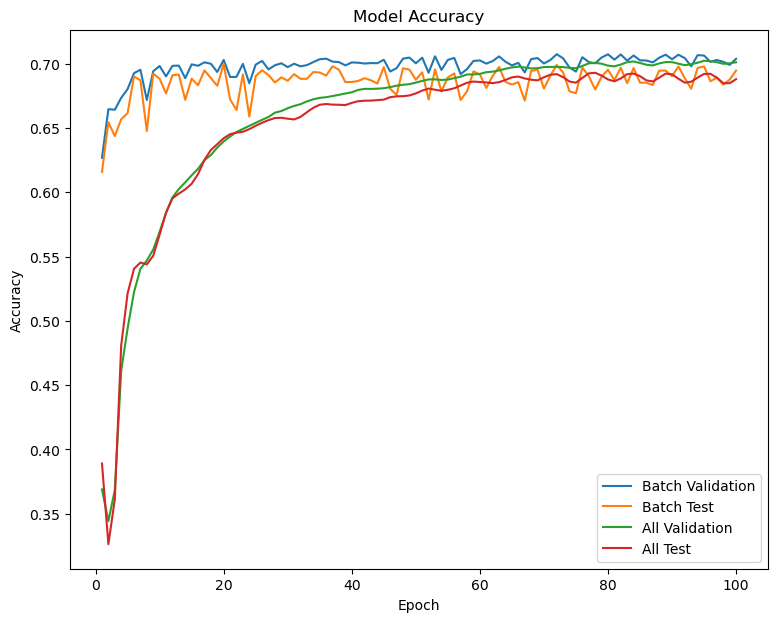

In [80]:
import numpy as np
from matplotlib import pyplot as plt

if 'IS_GRADESCOPE_ENV' not in os.environ:
  batch_results = np.array(batch_results)
  all_results = np.array(all_results)

  x = np.arange(1, 101)

  plt.figure(figsize=(9, 7))

  plt.plot(x, batch_results[:, 1], label="Batch Validation")
  plt.plot(x, batch_results[:, 2], label="Batch Test")
  plt.plot(x, all_results[:, 1], label="All Validation")
  plt.plot(x, all_results[:, 2], label="All Test")
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

# Submission

You will need to submit three files on Gradescope to complete this notebook. 

1.   Your completed *XCS224W_Colab4.ipynb*. From the "File" menu select "Download .ipynb" to save a local copy of your completed Colab. 
2.  *ACM-Node-MeanAgg.csv* 
3.  *ACM-Node-AttentionAgg.csv*
4.  *ogbn-arxiv_batch.csv* 

Download the csv files by selecting the *Folder* icon on the left panel. 

To submit your work, zip the files downloaded in steps 1-3 above and submit to gradescope. **NOTE:** DO NOT rename any of the downloaded files. 